In [1]:
import imp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import axelrod as axl
import axelrod.interaction_utils as iu

import testzd as zd

C, D = axl.Action.C, axl.Action.D

In [2]:
parameters = imp.load_source('parameters', 'data/raw/parameters.py')

# Extortionate zero determinant.

In [1], given a match between 2 memory one strategies the concept of Zero Determinant strategies is introduced. It was showed that a player $p\in\mathbb{R}^4$ against a player $q\in\mathbb{R}^4$ could force a linear relationship between the scores.

Assuming the following:

- The utilities for player $p$: $S_x = (R, S, T, P)$ and for player $q$: $S_y = (R, T, S, P)$.
- The normalised long run score for player $p$: $s_x$ and for player $q$: $s_y$.
- Given $p=(p_1, p_2, p_3, p_4)$ a transformed (but equivalent) vector: $\tilde p=(p_1 - 1, p_2 - 1, p_3, p_4)$, similarly: $\tilde q=(1 - q_1, 1 - q_2, q_3, q_4)$

The main result of [1] is that:

if $\tilde p = \alpha S_x + \beta S_y + \gamma 1$ **or** if $\tilde q = \alpha S_x + \beta S_y + \gamma 1$ then:

$$
\alpha s_x + \beta s_y + \gamma 1 = 0
$$

where $\alpha, \beta, \gamma \in \mathbb{R}$

As an example consider the `extort-2` strategy defined in [2]. This is given by:

$$p=(8/9, 1/2, 1/3, 0)$$

Let us use the `Axelrod` library [4, 5] to simulate some matches, here it is against some of the best strategies in the Axelrod library:

In [3]:
extort2 = axl.ZDExtort2()
players = (extort2, axl.EvolvedFSM16())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
scores = match.final_score_per_turn()
np.round((scores[0] - 1) / (scores[1] - 1), 3)

1.998

In [4]:
players = (extort2, axl.EvolvedANN5())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
scores = match.final_score_per_turn()
np.round((scores[0] - 1) / (scores[1] - 1), 3)

2.0

In [5]:
players = (extort2, axl.PSOGamblerMem1())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
scores = match.final_score_per_turn()
np.round((scores[0] - 1) / (scores[1] - 1), 3)

2.051

In [6]:
players = (extort2, extort2)
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
scores = match.final_score_per_turn()
(scores[0] - 1) / (scores[1] - 1)

1.0

We see that `extort2` beats all these strategies but gets a low score against itself.

In [1], in fact a specific type of Zero determinant strategy is considered, indeed if: $\gamma=-(\alpha + \beta)P$ then the relationship $\chi = S_X / S_Y$ holds where $\chi = \frac{-\beta}{\alpha}$ so that the $S_X - P$ will be at $\chi$ times bigger than $S_Y - P$ as long as $\chi > 1$. We can obtain a simple linear equation and an inequality that checks if a strategy is of this form:

In [7]:
p = np.array([8 / 9, 1 / 2, 1 / 3, 0])
zd.is_ZD(p)

True

In [8]:
np.round(p, 3)

array([0.889, 0.5  , 0.333, 0.   ])

Note however that even if there is a slight measurement error then these equations will fail:

In [9]:
np.random.seed(0)
approximate_p = p + 10 ** -5 * np.random.random(4)
np.round(np.max(np.abs(p - approximate_p)), 3)

0.0

In [10]:
zd.is_ZD(approximate_p)

False

Thus, this work proposes a statistical approach for recognising extortionate behaviour. This uses a least squares minimisation approach for the underlying linear algebraic problem being solved.

In [11]:
x, SSError = zd.compute_least_squares(approximate_p)
alpha, beta = x
chi = -beta / alpha
np.round(chi, 3)

2.0

In the paper, exact algebraic expressions for these measure have also been obtained:

In [12]:
x, SSError = zd.get_least_squares(approximate_p)
alpha, beta = x
chi = -beta / alpha
np.round(chi, 3)

2.0

Using the large data set of collected matches we can confirm the obtained formulae:

In [13]:
try:
    df = pd.read_csv("./data/processed/full/std/overall/main.csv")
    assert (np.all(np.isclose(df["residual"], df["computed_residual"])) and 
            np.all(np.isclose(df["alpha"], df["computed_alpha"])) and
            np.all(np.isclose(df["beta"], df["computed_beta"])))
except FileNotFoundError:
    pass

We see that in the case of an approximation of `extort2` we recover the value of $\chi=2$ (to the third decimal place).

The value that is in fact being minimised is called: $\text{SSError}$. This in fact gives us a measure of how far from being an extortionate strategy a given strategy vector $p$ is.

While all strategies are not necessarily memory one: so do not necessarily have a representation as a 4 dimensional vector. Their transition rates from all states to any action can still be measured.

Let us see how this works, using the 3 strategies above:

In [14]:
def get_p_from_interactions(interactions):
    vectors = []
    cooperations = iu.compute_cooperations(interactions)
    for player, (coop_count, state_counter) in enumerate(zip(
        cooperations, 
        iu.compute_state_to_action_distribution(interactions)
    )):
        p = []
        for state in ((C, C), (C, D), (D, C), (D, D)):
            if player == 1:
                state = state[::-1]
            try:
                p.append(state_counter[(state, C)] / (state_counter[(state, C)]  + state_counter[(state, D)] ) )
            except ZeroDivisionError:
                p.append(coop_count / len(interactions))
        vectors.append(p)
    return np.array(vectors)

In [15]:
players = (extort2, axl.EvolvedFSM16())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
p = get_p_from_interactions(interactions=interactions)[1]

In [16]:
np.round(p, 3)

array([0.375, 0.544, 0.472, 0.517])

In [17]:
x, SSError = zd.get_least_squares(p)
np.round(SSError, 3)

0.482

In [18]:
players = (extort2, axl.EvolvedANN5())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
p = get_p_from_interactions(interactions=interactions)[1]
x, SSError = zd.get_least_squares(p)
SSError

0.008494117647058819

This particular strategy in fact does not visit all states:

In [19]:
iu.compute_normalised_state_distribution(interactions=interactions)

Counter({(C, C): 0.0075, (D, C): 0.0025, (D, D): 0.99})

but the overall cooperation rate is used for the missing values:

In [20]:
iu.compute_normalised_cooperation(interactions=interactions)[1]

0.01

In [21]:
p

array([1.  , 0.8 , 0.01, 0.  ])

In [22]:
players = (extort2, axl.PSOGambler2_2_2())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
p = get_p_from_interactions(interactions=interactions)[1]
x, SSError = zd.get_least_squares(p)
np.round(SSError, 3)

0.43

So it seems that the `PSOGambler2_2_2` is "less" extortionate than `EvolvedANN5`. Note: it is certainly not an extortionate strategy as $p_4 > 0$:

In [23]:
np.round(p, 3)

array([0.105, 0.002, 0.518, 0.505])

We can actually classify all potential extortionate strategies which is Figure 1 of the paper.

The paper extends this work to consider a LARGE number of strategies, and identifies if and when strategies actually exhibit extortionate behaviour.

We note that the strategies that exhibit strong evolutionary fitness are ones that are able to adapt their behaviour: they do not extort strong strategies (thus cooperation evolves) but they do extort weaker ones. For example, here is a list of strategies against which `EvolvedANN5` is close to being ZD (\\(\text{SS}_{\text{error}} < 0.05\\)):

In [24]:
for opponent in parameters.PLAYER_GROUPS["full"]:
    players = (axl.EvolvedANN5(), opponent)
    axl.seed(0)
    match = axl.Match(players, turns=parameters.TURNS)
    interactions = match.play()
    p = get_p_from_interactions(interactions=interactions)[0]
    x, SSError = zd.compute_least_squares(p)
    if SSError < 0.05:
        alpha, beta = x
        scores = match.final_score_per_turn()
        print(f"vs {opponent}, chi={round(-beta / alpha, 2)}, (S_X - 1)/(S_Y - 1)={round((scores[0] - 1) / (scores[1] - 1), 2)}")

vs Adaptive, chi=-6.22, (S_X - 1)/(S_Y - 1)=-4.06
vs AntiCycler, chi=-5.28, (S_X - 1)/(S_Y - 1)=-4.04
vs Anti Tit For Tat, chi=-3.64, (S_X - 1)/(S_Y - 1)=-4.04
vs Bully, chi=-4.03, (S_X - 1)/(S_Y - 1)=-4.06
vs Calculator, chi=7.64, (S_X - 1)/(S_Y - 1)=0.48
vs Cooperator Hunter, chi=-5.28, (S_X - 1)/(S_Y - 1)=-4.05
vs Cycler CCCCCD, chi=16.0, (S_X - 1)/(S_Y - 1)=-4.44
vs Cycler CCCD, chi=15.58, (S_X - 1)/(S_Y - 1)=-4.15
vs Cycler CCD, chi=15.53, (S_X - 1)/(S_Y - 1)=-4.13
vs Cycler DC, chi=14.74, (S_X - 1)/(S_Y - 1)=-4.18
vs Cycler CCCDCD, chi=15.53, (S_X - 1)/(S_Y - 1)=-4.14
vs DoubleResurrection, chi=16.0, (S_X - 1)/(S_Y - 1)=-7.53
vs Feld: 1.0, 0.5, 200, chi=0.32, (S_X - 1)/(S_Y - 1)=0.7
vs $\phi$, chi=-2.9, (S_X - 1)/(S_Y - 1)=-4.04
vs Hard Prober, chi=13.43, (S_X - 1)/(S_Y - 1)=0.0
vs Harrington, chi=16.0, (S_X - 1)/(S_Y - 1)=0.8
vs Hopeless, chi=15.56, (S_X - 1)/(S_Y - 1)=-4.08
vs Knowledgeable Worse and Worse, chi=16.0, (S_X - 1)/(S_Y - 1)=4.89
vs Negation, chi=-4.03, (S_X - 1)/(S

This work shows here that not only is there a mathematical basis for suspicion: the calculation of $\text{SSError}$ but that some high performing strategies seem to exhibit suspicious behaviour that allows them to adapt.

## References

[1] Press, William H., and Freeman J. Dyson. "Iterated Prisoner’s Dilemma contains strategies that dominate any evolutionary opponent." Proceedings of the National Academy of Sciences 109.26 (2012): 10409-10413

[2] Stewart, Alexander J., and Joshua B. Plotkin. "Extortion and cooperation in the Prisoner’s Dilemma." Proceedings of the National Academy of Sciences 109.26 (2012): 10134-10135.

[3] Golub, Gene H., and Charles F. Van Loan. Matrix computations. Vol. 3. JHU Press, 2012.

[4] The Axelrod project developers. Axelrod: v4.2.0. 2016. http://doi.org/10.5281/zenodo.1252994

[5] Knight, Vincent, et al. "An Open Framework for the Reproducible Study of the Iterated Prisoner’s Dilemma." Journal of Open Research Software 4.1 (2016).

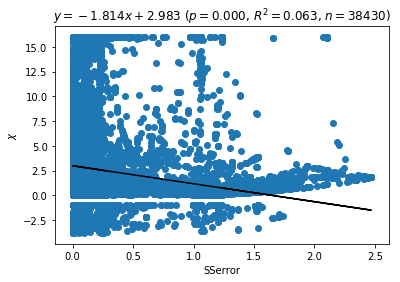